In [1]:
%load_ext rpy2.ipython

Exception reporting mode: Plain


In [2]:
%%R
library(tidyverse)
library(ggpubr)
library(phyloseq)
library(readxl)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Prepare data

### Taxonomic profile

In [3]:
%%R
tax_file <- "data/metaphlan3.merged.abundance.profile.species.272S.tsv"
tax_s <- read_tsv(tax_file)
tax_s_l <-
    tax_s %>%
    rowwise() %>%
    mutate(Species=str_split(clade_name, "\\|s__")[[1]][2]) %>%
    ungroup() %>%
    pivot_longer(
        names_to="sample_id",
        values_to="Abundance",
        -c(clade_name, Species))

dim(tax_s_l)

Rows: 547 Columns: 273
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr   (1): clade_name
dbl (272): VAC003B-M1_S2, VAC005B-M1_S3, VAC007B-M1_S4, VAC010B-M1_S5, VAC01...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
[1] 148784      4


In [271]:
%%R
tax_file_p <- "data/metaphlan3.merged.abundance.profile.phylum.272S.tsv"
tax_p <- read_tsv(tax_file_p)
tax_p_l <-
    tax_p %>%
    rowwise() %>%
    mutate(Phylum=str_split(clade_name, "\\|p__")[[1]][2]) %>%
    ungroup() %>%
    pivot_longer(
        names_to="sample_id",
        values_to="Abundance",
        -c(clade_name, Phylum))

dim(tax_p_l)

Rows: 12 Columns: 273
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr   (1): clade_name
dbl (272): VAC003B-M1_S2, VAC005B-M1_S3, VAC007B-M1_S4, VAC010B-M1_S5, VAC01...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
[1] 3264    4


In [5]:
%%R
547 * 272

[1] 148784


### Metadata

In [236]:
%%R
samples_metadata <-
    read_tsv("metadata/samples_metadata_imm_272S.tsv")
    

paired_ID <- count(samples_metadata, ID) %>% filter(n==2) %>% select(ID) %>% as.list()

samples_metadata_paired <-
    samples_metadata %>% filter(ID %in% paired_ID$ID)

Rows: 272 Columns: 57
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): sample_id, ID, TimePoint, Cohort, Vac_Group, Dose1_AE_num_cat, Dos...
dbl (50): all_bray_cluster3, Age, Male, BMI, OWOB, Obese_bin, HTC_bin, DMC_b...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
%%R
samples_metadata_ae <-
    read_tsv("metadata/samples_metadata_imm_ae_138S.tsv")

Rows: 275 Columns: 93
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (8): sample_id, ID, TimePoint, Cohort, Vac_Group, Dose1_AE_num_cat, Dos...
dbl (85): all_bray_cluster3, Age, Male, BMI, OWOB, Obese_bin, HTC_bin, DMC_b...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Merge tax profile and metadata

In [9]:
%%R
tax_s_l_ae <- tax_s_l %>% inner_join(samples_metadata_ae)
tax_s_l_272S <- tax_s_l %>% inner_join(samples_metadata)
tax_s_l_268S <- tax_s_l %>% inner_join(samples_metadata_paired)
tax_p_l_268S <- tax_p_l %>% inner_join(samples_metadata_paired)

Joining, by = "sample_id"


## LEfSe analysis

### Species with immune binary group among D0 OWOB population

In [48]:
%%R
samples_metadata_owob_group <-
    samples_metadata_ae %>%
    filter(TimePoint=="D0") %>%
    select(sample_id, ID, Vac_Group, OWOB, BMI,
           AUC_100_12800, M1_sVNT_10, M1_sVNT_200, M1_sVNT,
           RBD_binary_group, sVNT_binary_group, sVNT_60percent_binary_group) %>%
    distinct() %>%
    filter(!is.na(BMI)) %>%
    group_by(OWOB) %>%
    mutate(RBD_median=median(AUC_100_12800)) %>%
    mutate(RBD_median_group=case_when(
        AUC_100_12800 >= RBD_median ~ 1,
        AUC_100_12800 < RBD_median ~ 0))

In [50]:
%%R
tax_s_l_owob <- tax_s_l %>% right_join(samples_metadata_owob_group)

Joining, by = "sample_id"


## Extended Figure 7

#### OWOB1 and sVNT 60percent SinoVac

In [96]:
%%R
tax_s_l_d0_owob_1_sinovac_sVNT_60percent_binary_group <-
    tax_s_l_owob %>%
    filter(OWOB==1) %>%
    filter(Vac_Group=="SinoVac") %>%
    select(sample_id, Species, Abundance, sVNT_60percent_binary_group) %>%
    group_by(Species) %>%
    mutate(Species_abun_sum=sum(Abundance)) %>%
    filter(!Species_abun_sum<=0.0) %>%
    select(-Species_abun_sum) %>%
    ungroup()

tax_s_l_d0_owob_1_sinovac_sVNT_60percent_binary_group_2 <-
    tax_s_l_d0_owob_1_sinovac_sVNT_60percent_binary_group %>%
    select(sample_id, sVNT_60percent_binary_group) %>%
    distinct() %>%
    mutate(Species="sVNT_60percent_binary_group") %>%
    rename(Abundance=sVNT_60percent_binary_group) %>%
    mutate(Abundance=as.numeric(Abundance))

tax_s_l_d0_owob_1_sinovac_sVNT_60percent_binary_group_w <-
    tax_s_l_d0_owob_1_sinovac_sVNT_60percent_binary_group_2 %>%
    bind_rows(tax_s_l_d0_owob_1_sinovac_sVNT_60percent_binary_group %>%
    select(sample_id, Species, Abundance)) %>%
    pivot_wider(names_from=sample_id, values_from=Abundance)
    
print(dim(tax_s_l_d0_owob_1_sinovac_sVNT_60percent_binary_group_w))
write_tsv(tax_s_l_d0_owob_1_sinovac_sVNT_60percent_binary_group_w,
          "tables/lefse/tax_s_lefse_D0_OWOB1_sinovac_sVNT_60percent_binary_group_w.tsv")

[1] 246  16


In [97]:
!lefse_format_input.py \
tables/lefse/tax_s_lefse_D0_OWOB1_sinovac_sVNT_60percent_binary_group_w.tsv \
tables/lefse/tax_s_lefse_D0_OWOB1_sinovac_sVNT_60percent_binary_group_w.lefse.in  \
-c 2 -u 1 -o 1000000

!lefse_run.py \
tables/lefse/tax_s_lefse_D0_OWOB1_sinovac_sVNT_60percent_binary_group_w.lefse.in \
tables/lefse/tax_s_lefse_D0_OWOB1_sinovac_sVNT_60percent_binary_group_w.lefse.out.tsv

Number of significantly discriminative features: 9 ( 9 ) before internal wilcoxon
Number of discriminative features with abs LDA score > 2.0 : 6
R[write to console]: Warning messages:

R[write to console]: 1: package ‘survival’ was built under R version 4.0.5 

R[write to console]: 2: package ‘mvtnorm’ was built under R version 4.0.5 

R[write to console]: 3: package ‘modeltools’ was built under R version 4.0.5 



In [98]:
%%R
lefse <- read_tsv("tables/lefse/tax_s_lefse_D0_OWOB1_sinovac_sVNT_60percent_binary_group_w.lefse.out.tsv",
                  col_names=c("Species", "v1", "group", "LDA_score", "pvalue")) %>%
filter(!is.na(group)) %>%
mutate(LDA_score=case_when(
    group==0 ~ (-LDA_score),
    TRUE ~ LDA_score)) %>%
mutate(group=factor(group, levels=c("0", "1")))

Rows: 245 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Species, pvalue
dbl (3): v1, group, LDA_score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


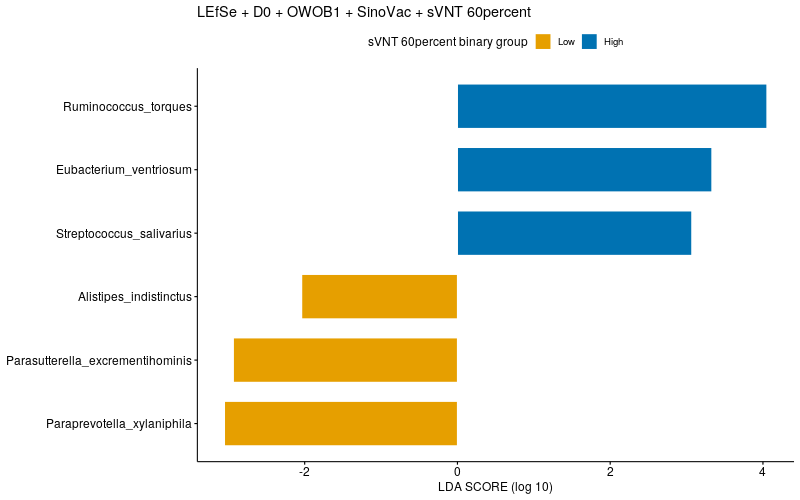

In [99]:
%%R -w 800 -h 500
p <- ggbarplot(
    lefse, x = "Species", y = "LDA_score",
    fill = "group",
    color = "white",
    sort.val = "asc",
    sort.by.groups = TRUE,
    ylab= FALSE,
    rotate = TRUE,
    legend.title = "sVNT 60percent binary group") +
ggtitle("LEfSe + D0 + OWOB1 + SinoVac + sVNT 60percent") +
ylab("LDA SCORE (log 10)") +
scale_fill_manual(breaks=c("0", "1"), labels=c("Low", "High"),
                  values=c("0"="#E69F00", "1"="#0072B2"))

print(p)
ggsave("figures/species_lefse_D0_OWOB1_sinovac_sVNT_60percent_binary_group.pdf", p, width=8, height=8)

In [100]:
%%R
tax_s_lefse_summary <-
    tax_s_l_d0_owob_1_sinovac_sVNT_60percent_binary_group %>% group_by(Species) %>%
        summarise(abun_median=median(Abundance),
              abun_quartile_0=quantile(Abundance, 0.00),
              abun_quartile_25=quantile(Abundance, 0.25),
              abun_quartile_50=quantile(Abundance, 0.50),
              abun_quartile_75=quantile(Abundance, 0.75),
              abun_quartile_100=quantile(Abundance, 1.00))
tax_s_enrichment <- tax_s_lefse_summary %>% right_join(lefse)
print(tax_s_enrichment)
write_tsv(tax_s_enrichment, "tables/lefse/tax_s_lefse_D0_OWOB1_sinovac_sVNT_60percent_binary_group_abun.tsv")

Joining, by = "Species"
# A tibble: 6 × 11
  Species          abun_median abun_quartile_0 abun_quartile_25 abun_quartile_50
  <chr>                  <dbl>           <dbl>            <dbl>            <dbl>
1 Alistipes_indis…  0.00000821               0        0               0.00000821
2 Eubacterium_ven…  0.00125                  0        0.0000945       0.00125   
3 Paraprevotella_…  0.000201                 0        0               0.000201  
4 Parasutterella_…  0                        0        0               0         
5 Ruminococcus_to…  0.00821                  0        0.00127         0.00821   
6 Streptococcus_s…  0.000573                 0        0.000187        0.000573  
# … with 6 more variables: abun_quartile_75 <dbl>, abun_quartile_100 <dbl>,
#   v1 <dbl>, group <fct>, LDA_score <dbl>, pvalue <chr>


### Species with Immune Binary group among all D0 people

In [165]:
%%R
lefse_py_bnt <- read_excel("data/Bivariate_analysis_GLM_clusters-Sep-28-2021.xlsx", sheet=6)

R[write to console]: New names:
* `` -> ...2



In [167]:
%%R
lefse_py_bnt <-
    lefse_py_bnt %>%
filter(!is.na(Enrichment)) %>%
mutate(`LDA score`=case_when(
    Enrichment==1 ~ (-`LDA score`),
    TRUE ~ `LDA score`)) %>%
mutate(Enrichment=factor(Enrichment, levels=c("1", "2")))

## Extended Figure 9d and 9h

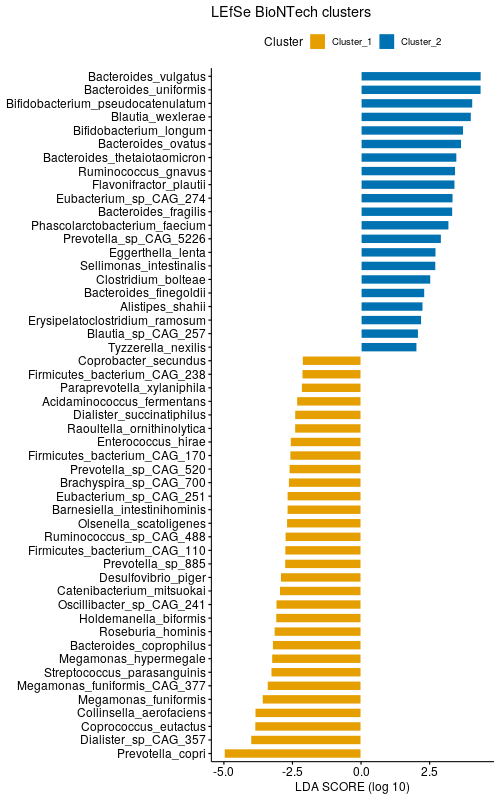

In [170]:
%%R -w 500 -h 800
p <- ggbarplot(lefse_py_bnt, x = "Species", y = "LDA score",
          fill = "Enrichment",           # change fill color by mpg_level
          color = "white",            # Set bar border colors to white
          sort.val = "asc",           # Sort the value in ascending order
          sort.by.groups = TRUE,     # Don't sort inside each group
          rotate = TRUE,
          ylab=FALSE,
          legend.title = "Cluster") + ggtitle("LEfSe BioNTech clusters")  +
ylab("LDA SCORE (log 10)") +
scale_fill_manual(breaks=c(1, 2), labels=c("Cluster_1", "Cluster_2"),
                  values=c("2"="#0072B2", "1"="#E69F00"))
#scale_y_log10() #+
#scale_fill_manual(name = "RBD group", breaks=c("0", "1"), labels=c("Low", "Higher"))

print(p)
ggsave("tables/lefse/species_lefse_biontech_cluster.pdf", p, width=8, height=10)

#### SinoVac

In [171]:
%%R
lefse_py_snv <- read_excel("data/Bivariate_analysis_GLM_clusters-Sep-28-2021.xlsx", sheet=7)

R[write to console]: New names:
* `` -> ...2



In [172]:
%%R
lefse_py_snv <-
    lefse_py_snv %>%
filter(!is.na(Enrichment)) %>%
mutate(`LDA score`=case_when(
    Enrichment==1 ~ (-`LDA score`),
    TRUE ~ `LDA score`)) %>%
mutate(Enrichment=factor(Enrichment, levels=c("1", "2")))

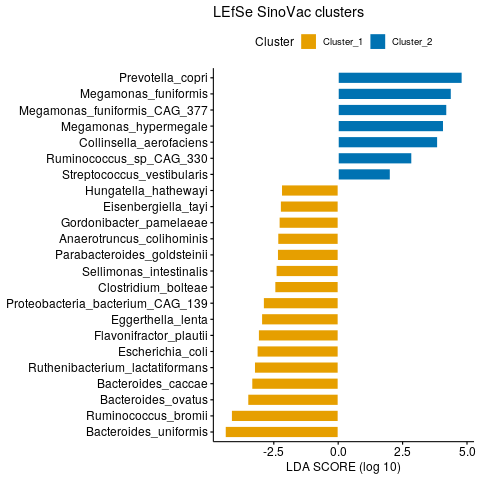

In [173]:
%%R
p <- ggbarplot(lefse_py_snv, x = "Species", y = "LDA score",
          fill = "Enrichment",           # change fill color by mpg_level
          color = "white",            # Set bar border colors to white
          sort.val = "asc",           # Sort the value in ascending order
          sort.by.groups = TRUE,     # Don't sort inside each group
          ylab = FALSE,
          rotate = TRUE,
          legend.title = "Cluster") + ggtitle("LEfSe SinoVac clusters")  +
ylab("LDA SCORE (log 10)") +
scale_fill_manual(breaks=c(1, 2), labels=c("Cluster_1", "Cluster_2"),
                  values=c("2"="#0072B2", "1"="#E69F00"))
#scale_y_log10() #+
#scale_fill_manual(name = "RBD group", breaks=c("0", "1"), labels=c("Low", "Higher"))

print(p)
ggsave("figures/species_lefse_sinovac_cluster.pdf", p, width=8, height=8)

#### Redo lefse and cluster

In [174]:
%%R

samples_metadata <- read_tsv("metadata/samples_metadata_imm_272S.tsv")

Rows: 272 Columns: 57
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): sample_id, ID, TimePoint, Cohort, Vac_Group, Dose1_AE_num_cat, Dos...
dbl (50): all_bray_cluster3, Age, Male, BMI, OWOB, Obese_bin, HTC_bin, DMC_b...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [175]:
%%R
tax_s_l_metadata <-
    tax_s_l %>%
    inner_join(samples_metadata)
    
print(dim(tax_s_l_metadata))

Joining, by = "sample_id"
[1] 148784     60


##### BioNTech

In [177]:
%%R
tax_s_lefse_biontech_cluster <-
    tax_s_l_metadata %>%
    filter(TimePoint=="D0" & Vac_Group=="BioNTech") %>%
    select(sample_id, Species, Abundance, BNT_jsd_cluster2) %>%
    distinct() %>%
    group_by(Species) %>%
    mutate(Species_abun_sum=sum(Abundance)) %>%
    filter(!Species_abun_sum<=0.0) %>%
    select(-Species_abun_sum) %>%
    ungroup()
    
tax_s_lefse_biontech_cluster_2 <-
    tax_s_lefse_biontech_cluster %>%
    select(sample_id, BNT_jsd_cluster2) %>%
    distinct() %>%
    mutate(Species="JSD_Cluster") %>%
    rename(Abundance=BNT_jsd_cluster2)
    
tax_s_lefse_biontech_cluster_w <-
    tax_s_lefse_biontech_cluster_2 %>%
    bind_rows(tax_s_lefse_biontech_cluster %>%
    select(sample_id, Species, Abundance)) %>%
    pivot_wider(names_from=sample_id, values_from=Abundance)

print(dim(tax_s_lefse_biontech_cluster_w))
write_tsv(tax_s_lefse_biontech_cluster_w, "tables/lefse/tax_s_lefse_D0_biontech_JSD_cluster.tsv")

[1] 464 102


In [178]:
!lefse_format_input.py \
tables/lefse/tax_s_lefse_D0_biontech_JSD_cluster.tsv \
tables/lefse/tax_s_lefse_D0_biontech_JSD_cluster.lefse.in \
-c 2 -u 1 -o 1000000

!lefse_run.py \
tables/lefse/tax_s_lefse_D0_biontech_JSD_cluster.lefse.in \
tables/lefse/tax_s_lefse_D0_biontech_JSD_cluster.lefse.out.tsv

Number of significantly discriminative features: 77 ( 77 ) before internal wilcoxon
Number of discriminative features with abs LDA score > 2.0 : 51
R[write to console]: Warning messages:

R[write to console]: 1: package ‘survival’ was built under R version 4.0.5 

R[write to console]: 2: package ‘mvtnorm’ was built under R version 4.0.5 

R[write to console]: 3: package ‘modeltools’ was built under R version 4.0.5 



In [203]:
%%R
lefse <- read_tsv("tables/lefse/tax_s_lefse_D0_biontech_JSD_cluster.lefse.out.tsv",
                  col_names=c("Species", "v1", "group", "LDA_score", "pvalue")) %>%
filter(!is.na(group)) %>%
mutate(LDA_score=case_when(
    group==1 ~ (-LDA_score),
    TRUE ~ LDA_score)) %>%
mutate(group=factor(group, levels=c("1", "2")))

Rows: 463 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Species, pvalue
dbl (3): v1, group, LDA_score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


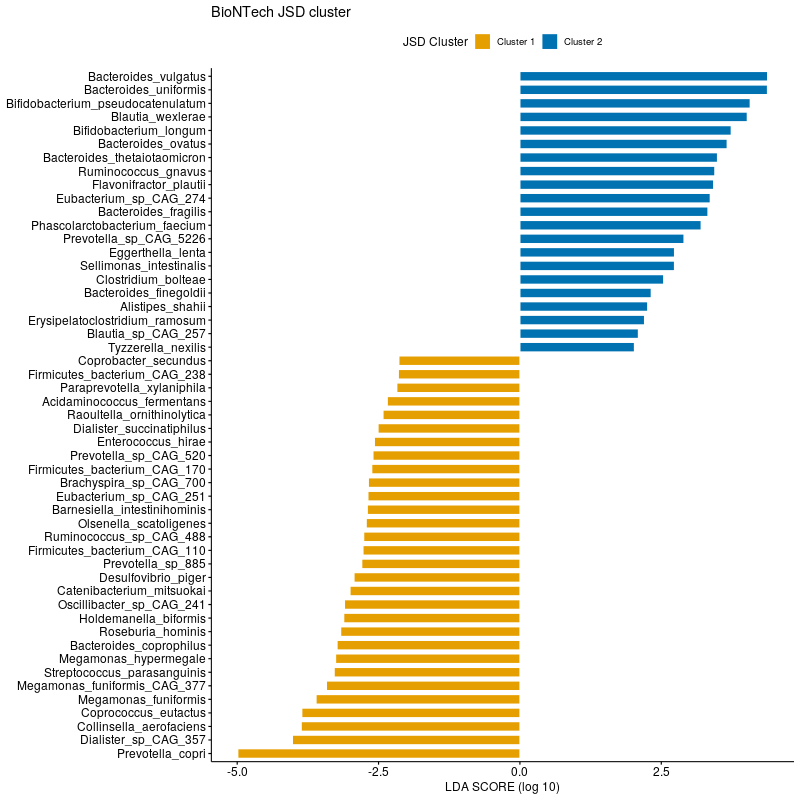

In [205]:
%%R -w 800 -h 800
p <- ggbarplot(
    lefse, x = "Species", y = "LDA_score",
    fill = "group",
    color = "white",
    sort.val = "asc",
    sort.by.groups = TRUE,
    ylab= FALSE,
    rotate = TRUE,
    legend.title = "JSD Cluster") +
ggtitle("BioNTech JSD cluster") +
ylab("LDA SCORE (log 10)") +
scale_fill_manual(breaks=c("1", "2"), labels=c("Cluster 1", "Cluster 2"),
                  values=c("1"="#E69F00", "2"="#0072B2"))

print(p)
ggsave("figures/species_lefse_D0_biontech_JSD_cluster.pdf", p, width=8, height=12)

In [181]:
%%R
tax_s_lefse_summary <-
    tax_s_lefse_biontech_cluster %>% group_by(Species) %>%
        summarise(abun_median=median(Abundance),
              abun_quartile_0=quantile(Abundance, 0.00),
              abun_quartile_25=quantile(Abundance, 0.25),
              abun_quartile_50=quantile(Abundance, 0.50),
              abun_quartile_75=quantile(Abundance, 0.75),
              abun_quartile_100=quantile(Abundance, 1.00))
tax_s_enrichment <- tax_s_lefse_summary %>% right_join(lefse)
print(tax_s_enrichment)
write_tsv(tax_s_enrichment, "tables/lefse/tax_s_lefse_D0_biontech_JSD_cluster_abun.tsv")

Joining, by = "Species"
# A tibble: 51 × 11
   Species         abun_median abun_quartile_0 abun_quartile_25 abun_quartile_50
   <chr>                 <dbl>           <dbl>            <dbl>            <dbl>
 1 Acidaminococcu…    0                      0         0                0       
 2 Alistipes_shah…    0.000362               0         0                0.000362
 3 Bacteroides_co…    0                      0         0                0       
 4 Bacteroides_fi…    0                      0         0                0       
 5 Bacteroides_fr…    0                      0         0                0       
 6 Bacteroides_ov…    0.00280                0         0.000655         0.00280 
 7 Bacteroides_th…    0.00252                0         0.00101          0.00252 
 8 Bacteroides_un…    0.0281                 0         0.00695          0.0281  
 9 Bacteroides_vu…    0.0213                 0         0.00471          0.0213  
10 Barnesiella_in…    0                      0         0         

##### SinoVac

In [441]:
%%R
tax_s_lefse_sinovac_cluster <-
    tax_s_l_metadata %>%
    filter(TimePoint=="D0" & Vac_Group=="SinoVac") %>%
    select(sample_id, Species, Abundance, SNV_jsd_cluster2) %>%
    distinct() %>%
    group_by(Species) %>%
    mutate(Species_abun_sum=sum(Abundance)) %>%
    filter(!Species_abun_sum<=0.0) %>%
    select(-Species_abun_sum) %>%
    ungroup()
    
tax_s_lefse_sinovac_cluster_2 <-
    tax_s_lefse_sinovac_cluster %>%
    select(sample_id, SNV_jsd_cluster2) %>%
    distinct() %>%
    mutate(Species="JSD_Cluster") %>%
    rename(Abundance=SNV_jsd_cluster2)
    
tax_s_lefse_sinovac_cluster_w <-
    tax_s_lefse_sinovac_cluster_2 %>%
    bind_rows(tax_s_lefse_sinovac_cluster %>%
    select(sample_id, Species, Abundance)) %>%
    pivot_wider(names_from=sample_id, values_from=Abundance)

print(dim(tax_s_lefse_sinovac_cluster_w))
write_tsv(tax_s_lefse_sinovac_cluster_w, "tables/lefse/tax_s_lefse_D0_sinovac_JSD_cluster.tsv")

[1] 349  38


In [442]:
!lefse_format_input.py \
tables/lefse/tax_s_lefse_D0_sinovac_JSD_cluster.tsv \
tables/lefse/tax_s_lefse_D0_sinovac_JSD_cluster.lefse.in \
-c 2 -u 1 -o 1000000

!lefse_run.py \
tables/lefse/tax_s_lefse_D0_sinovac_JSD_cluster.lefse.in \
tables/lefse/tax_s_lefse_D0_sinovac_JSD_cluster.lefse.out.tsv

Number of significantly discriminative features: 28 ( 28 ) before internal wilcoxon
Number of discriminative features with abs LDA score > 2.0 : 23
R[write to console]: Warning messages:

R[write to console]: 1: package ‘survival’ was built under R version 4.0.5 

R[write to console]: 2: package ‘mvtnorm’ was built under R version 4.0.5 

R[write to console]: 3: package ‘modeltools’ was built under R version 4.0.5 



In [443]:
%%R
lefse <- read_tsv("tables/lefse/tax_s_lefse_D0_sinovac_JSD_cluster.lefse.out.tsv",
                  col_names=c("Species", "v1", "group", "LDA_score", "pvalue")) %>%
filter(!is.na(group)) %>%
mutate(LDA_score=case_when(
    group==1 ~ (-LDA_score),
    TRUE ~ LDA_score)) %>%
mutate(group=factor(group, levels=c("1", "2")))

Rows: 348 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Species, pvalue
dbl (3): v1, group, LDA_score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


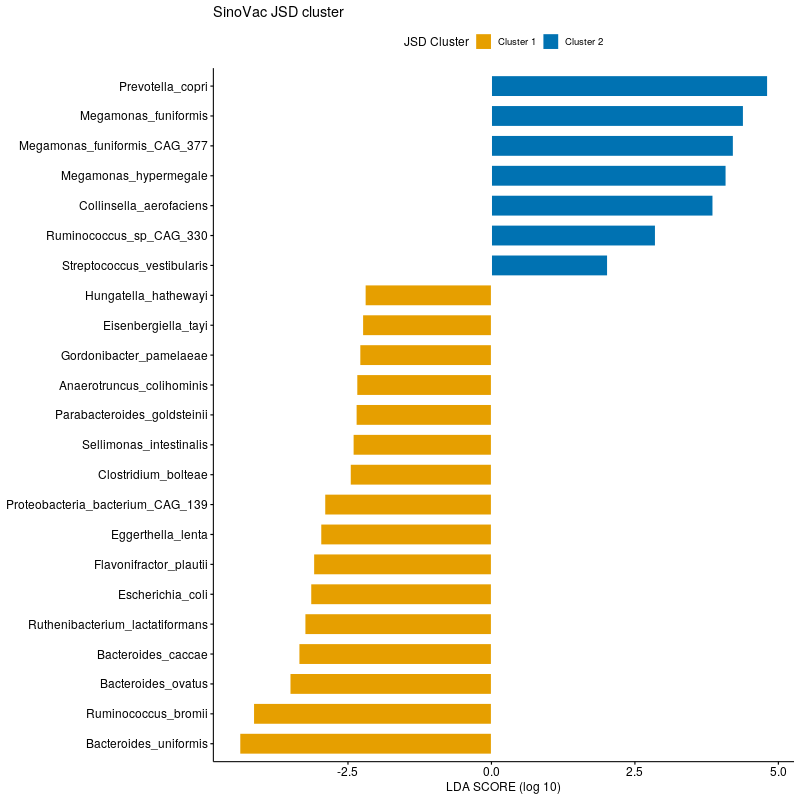

In [444]:
%%R -w 800 -h 800
p <- ggbarplot(
    lefse, x = "Species", y = "LDA_score",
    fill = "group",
    color = "white",
    sort.val = "asc",
    sort.by.groups = TRUE,
    ylab= FALSE,
    rotate = TRUE,
    legend.title = "JSD Cluster") +
ggtitle("SinoVac JSD cluster") +
ylab("LDA SCORE (log 10)") +
scale_fill_manual(breaks=c("1", "2"), labels=c("Cluster 1", "Cluster 2"),
                  values=c("1"="#E69F00", "2"="#0072B2"))

print(p)
ggsave("tables/lefse/species_lefse_D0_sinovac_JSD_cluster.pdf", p, width=8, height=8)

In [445]:
%%R
tax_s_lefse_summary <-
    tax_s_lefse_sinovac_cluster %>% group_by(Species) %>%
        summarise(abun_median=median(Abundance),
              abun_quartile_0=quantile(Abundance, 0.00),
              abun_quartile_25=quantile(Abundance, 0.25),
              abun_quartile_50=quantile(Abundance, 0.50),
              abun_quartile_75=quantile(Abundance, 0.75),
              abun_quartile_100=quantile(Abundance, 1.00))
tax_s_enrichment <- tax_s_lefse_summary %>% right_join(lefse)
print(tax_s_enrichment)
write_tsv(tax_s_enrichment, "tables/lefse/tax_s_lefse_D0_sinovac_JSD_cluster_abun.tsv")

Joining, by = "Species"
# A tibble: 23 × 11
   Species         abun_median abun_quartile_0 abun_quartile_25 abun_quartile_50
   <chr>                 <dbl>           <dbl>            <dbl>            <dbl>
 1 Anaerotruncus_…  0.00000594       0                0               0.00000594
 2 Bacteroides_ca…  0.00292          0                0               0.00292   
 3 Bacteroides_ov…  0.00318          0                0.00121         0.00318   
 4 Bacteroides_un…  0.0335           0.000939         0.0158          0.0335    
 5 Clostridium_bo…  0.000126         0                0               0.000126  
 6 Collinsella_ae…  0.00661          0                0.0000740       0.00661   
 7 Eggerthella_le…  0.000355         0                0               0.000355  
 8 Eisenbergiella…  0                0                0               0         
 9 Escherichia_co…  0.000220         0                0               0.000220  
10 Flavonifractor…  0.00187          0.0000472        0.000966   

### M1

In [446]:
%%R
lefse_res_df_SNV_sVNT_60perc_M1 <-
    read_excel("data/pengye_LEfSe_results.xlsx", sheet=1) %>%
    filter(!is.na(group)) %>%
    mutate(LDA_score=case_when(
        group==0 ~ (-LDA_score),
        TRUE ~ LDA_score
    )) %>%
    mutate(group=factor(group, levels=c(0, 1)))

lefse_res_df_BNT_sVNT_Q1_M1 <-
    read_excel("data/pengye_LEfSe_results.xlsx", sheet=2) %>%
    filter(!is.na(group)) %>%
    mutate(LDA_score=case_when(
        group==0 ~ (-LDA_score),
        TRUE ~ LDA_score
    )) %>%
    mutate(group=factor(group, levels=c(0, 1)))

## Extended Figure 2a

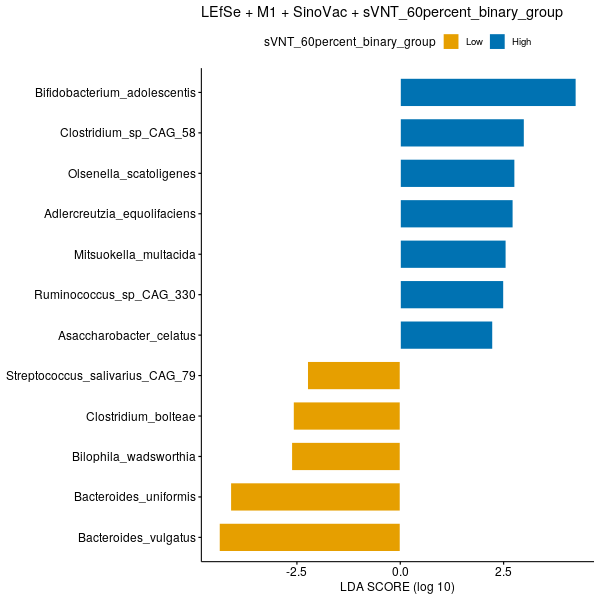

In [447]:
%%R -w 600 -h 600
p <- ggbarplot(
    lefse_res_df_SNV_sVNT_60perc_M1, x = "species", y = "LDA_score",
    fill = "group",
    color = "white",
    sort.val = "asc",
    sort.by.groups = TRUE,
    ylab= FALSE,
    rotate = TRUE,
    legend.title = "sVNT_60percent_binary_group") +
ggtitle("LEfSe + M1 + SinoVac + sVNT_60percent_binary_group") +
ylab("LDA SCORE (log 10)") +
scale_fill_manual(breaks=c("0", "1"), labels=c("Low", "High"),
                  values=c("0"="#E69F00", "1"="#0072B2"))

print(p)
ggsave("figures/species_lefse_M1_sinovac_sVNT_60percent_binary_group_py.pdf",
       p, width=8, height=8)

## Extended Figure 2b

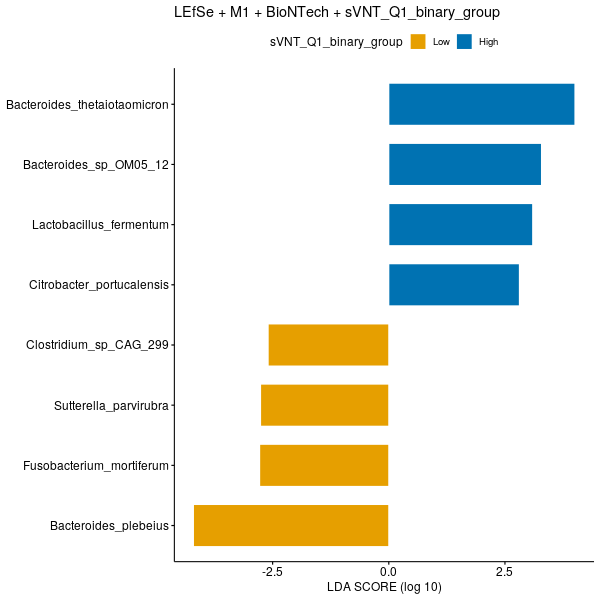

In [448]:
%%R -w 600 -h 600
#lefse_res_df_SNV_sVNT_60perc_M1
#lefse_res_df_BNT_sVNT_Q1_M1
#lefse_res_df_BNT_sVNT200_Q1
#lefse_res_df_SNV_sVNT10_60perc
#lefse_res_df_BNT_DOSE1_AE_2_or_more
#lefse_res_df_BNT_DOSE2_AE_2_or_more
#lefse_res_df_SNV_Dose1_AE
#lefse_res_df_SNV_Dose2_AE
p <- ggbarplot(
    lefse_res_df_BNT_sVNT_Q1_M1, x = "species", y = "LDA_score",
    fill = "group",
    color = "white",
    sort.val = "asc",
    sort.by.groups = TRUE,
    ylab= FALSE,
    rotate = TRUE,
    legend.title = "sVNT_Q1_binary_group") +
ggtitle("LEfSe + M1 + BioNTech + sVNT_Q1_binary_group") +
ylab("LDA SCORE (log 10)") +
scale_fill_manual(breaks=c("0", "1"), labels=c("Low", "High"),
                  values=c("0"="#E69F00", "1"="#0072B2"))

print(p)
ggsave("figures/species_lefse_M1_biontech_sVNT_binary_group_py.pdf",
       p, width=8, height=8)